## **Context**

This code partially replicates the results from Gilraine, Macartney, and McMillan (2018), extending their analysis with a staggered Difference-in-Differences approach. The results might slightly differ since we are using a different program than the authors. The paper introduces a method to jointly estimate the direct and indirect effects of major education reforms, focusing on California’s Class Size Reduction (CSR) program—a statewide initiative launched in the late 1990s that incentivized public schools to reduce class sizes to 20 or fewer students in grades K–3, with a staggered rollout beginning in 1996–97. In direct words, the treatment analyzed here is class size reduction, implemented through California’s CSR program.

## **Variables Defintions**

In “PS2 data.csv.”, we have:

- district code: district identifier
- grade: grade
- year: school year (denoted as fall of school year so 1990 is 1990-91 school year)
- share: private school share
- enr: total district enrollment (private + public)
- demographic controls: pctep, asianpct, hisppct, afampct, whitepct, pacificpct, nativepct, malepct

## **Library Imports**

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import re
from linearmodels import PanelOLS
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

## **Upload File**

In [2]:
# Upload csv file as data frame
df = pd.read_csv("PS2_data.csv")

# Visualize data frame
df.head()

,district_code,grade,year,share,enr,pctep,asianpct,hisppct,afampct,whitepct,pacificpct,nativepct,malepct
0,6651,1,2002,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6651,4,2002,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6651,6,2002,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6651,8,2002,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6651,9,2002,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Define Event Time**

Treatment is introduced in 1996, 1997, and 1998 for the Grade 1, Grade 2, Grade 3, and Kindergarten cohorts, respectively.

We define an **event time** variable to align all treatments as occurring at a common period 0.

For all untreated grades, we consider the base year of treatment as 1996.

For treated grades, if students are observed in their respective treatment year (e.g., 1996, 1997, or 1998), we treat that year as their base year of treatment. Otherwise, we assign 1996 as the base year of treatment. For example, if a Grade 2 student is observed in 1997, we use 1997 as the treatment year; if observed in 2006, we default to 1996 as the treatment year.

Thus, we define:

- ``event_time = year - year of treatment``
- ``treated:`` equals 1 if part of treated group; 0 otherwise
- ``post:`` equals 1 if post treatment period; 0 otherwise

In [3]:
# Define treatment years
treatment_years={
    0: 1998,   # Kindergarten = grade 0; treated in 1998
    1: 1996,   # Grade 1; treated 1996
    2: 1997,   # Grade 2; treated 1997
    3: 1998    # Grade 3; treated 1998
}

# Function to rewrite treatment years in terms of the treatment period 
def get_treat_year(grade):
    """
    Returns the first treatment year for a given grade if the grade is treated,
    and returns 1996 for untreated grades (per the instructions).
    """
    return treatment_years.get(grade, 1996)

# Set treated group using the function above
df['treated'] = df['grade'].apply(lambda g: 1 if g in treatment_years else 0)

# Event_time: (current year) - (year treatment began)
df['event_time'] = df.apply(lambda row: row['year'] - get_treat_year(row['grade']), axis=1)

# Define post-period of treatment
df['post'] = df.apply(lambda row: 1 if row['year'] >= get_treat_year(row['grade']) else 0, axis=1)

## **Event-Study Graph**

The Difference-in-Differences design is valid only if – absent treatment – the treated and control units would have followed **parallel trends**. We can check this assumption by utilizng a event-study graph. 

An event-study graph is a visual that plots the estimated treatment‐group minus control‐group differences period-by-period around the moment an intervention (“event”) starts. We run a regression that allows the treatment effect to vary with event time k:

$ Y_{it} = \alpha + \sum_{k \neq -1} \beta_k\bigl(\text{Treat}_i \times \mathbf{1}\{\text{event time}=k\}\bigr) + \gamma_i + \lambda_t + \varepsilon_{it} $

where

- $\text{Treat}_i$ = 1 for treated unit 
- event time = k – dummy that equals 1 in period k relative to treatment start (k = 0 is the first treated period; k = –1 is omitted and serves as the reference year)
- $\gamma_i$ and $\lambda_t$ are fixed effects

In the event-study regression parallel trends translates to:

$\beta_k = 0 \quad \text{for all } k < 0 \; (\text{pre-treatment leads})$

We can check this by inspecting the graph. We can observe if all lead coefficients (the dots left of k = –1) hover around zero and sit inside the 95 % confidence band containing zero. You can also do a formal F-test if you want to. 


#### Run the regression with event time '-1' as the reference:

**Obs**: I used statsmodel for running the regression. It may take a while (around 2min) to run. 

In [4]:
# Copy main data frame
df_event = df.copy()

# Transform event time into a categorical variable
df_event['event_time_cat'] = df_event['event_time'].astype('category')

# Filter out event_time < -6 (i.e. -7,-8) 
df_trimmed = df_event[df_event['event_time'] >= -6].copy()

formula = (
    "share ~ C(grade) + C(district_code)"
    "+ C(event_time_cat, Treatment(reference=-1))*treated"
    "+ pctep + asianpct + hisppct + afampct + whitepct "
    "+ pacificpct + nativepct + malepct"
)

model = smf.wls(formula=formula, data=df_trimmed, weights=df_trimmed['enr'])
results = model.fit()

#### Store the variables to be plotted in a dataframe:

In [5]:
# Store coefficients from event time
coefs = results.params.filter(like='event_time_cat')
ses   = results.bse.filter(like='event_time_cat') # Standard errors

# Loop through each parameter 
rows = []
for name in coefs.index:
    match = re.search(r'\[T\.(-?\d+\.?\d*)\]:treated$', name)
    if match:
        k = float(match.group(1))
        rows.append({
            'event_time': k,
            'coef': coefs[name],
            'se':   ses[name]
        })

# Define variables in a dataframe to be plotted
plot_df = pd.DataFrame(rows)
plot_df['lower'] = plot_df['coef'] - 1.96*plot_df['se']
plot_df['upper'] = plot_df['coef'] + 1.96*plot_df['se']

# Set coefficient at ‘-1’ to zero
baseline_row = pd.DataFrame({
    'event_time': [-1],
    'coef': [0.0],
    'se': [0.0],
    'lower': [0.0],
    'upper': [0.0]
})

# Combine baseline_row with rest of the dataframe
plot_df = pd.concat([plot_df, baseline_row], ignore_index=True)

# Sort values
plot_df = plot_df.sort_values('event_time')

# Drop first two rows (they are still present as zeros)
plot_df = plot_df.iloc[2:].reset_index(drop=True)
plot_df

,event_time,coef,se,lower,upper
0,-6.0,0.003253,0.001051,0.001194,0.005312
1,-5.0,0.003742,0.001043,0.001699,0.005785
2,-4.0,0.005087,0.001039,0.003050,0.007124
3,-3.0,0.002867,0.001034,0.000840,0.004895
4,-2.0,0.001121,0.001029,-0.000896,0.003137
5,-1.0,0.000000,0.000000,0.000000,0.000000
6,0.0,-0.002625,0.001017,-0.004618,-0.000633
7,1.0,-0.003055,0.001015,-0.005045,-0.001065
8,2.0,-0.002745,0.001015,-0.004735,-0.000756
9,3.0,-0.005694,0.001013,-0.007680,-0.003709


#### Plot the event study:

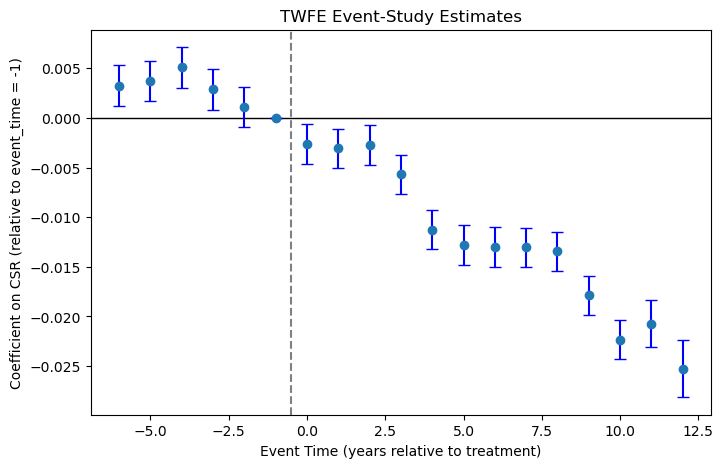

In [6]:
fig, ax = plt.subplots(figsize=(8,5))

# Set a horizontal line at 0
ax.axhline(0, color='black', linewidth=1)

# Set a vertical line just to highlight the boundary between k=-1 and k=0
ax.axvline(x=-0.5, color='gray', linestyle='--')

# Plot point estimates with error bars
ax.errorbar(
    plot_df['event_time'],
    plot_df['coef'],
    yerr=1.96*plot_df['se'],
    fmt='o', ecolor='blue', capsize=4
)

ax.set_xlabel('Event Time (years relative to treatment)')
ax.set_ylabel('Coefficient on CSR (relative to event_time = -1)')

plt.title('TWFE Event-Study Estimates')
plt.show()

#### Interpretation:

For parallel trends, we should observe a relativently flat disposition of the dot to the left of the dashed line. We see there is in fact some increasing and decreasing trends, but it is nothing major. 

## **Let's do the Difference-in-Differences (DiD) Regression by Hand**

The basic Two-Period DiD can be defined as:

$Y_{i,s,t}=\beta_0+\beta_1\left(Treat_s\times P o s t_t\right)+\beta_2Treat_s+\beta_3Post_t+\varepsilon_{ist}$

where

$\beta=\text{Average Treatment Effect on the Treated (Causal Effect)}$

, which can be calculated through:

$\beta=\left(E\left[Y\mid Treat=1,Post=1\right]-E\left[Y\mid Treat=1,Post=0\right]\right)-\left(E\left[Y\mid Treat=0,Post=1\right]-E\left[Y\mid Treat=0,Post=0\right]\right)$

Applying this to our case, we can find the **impact of the class reduction** on **private school shares** through:

1) Obtaining (enrollment-weighted) mean private school share before and after CSR was implemented in both treated and control grades
2) Then, calculating: $(Y_{1,1} - Y_{1,0}) - (Y_{0,1} - Y_{0,0})$

#### 1. Obtain weighted averages:

In [7]:
# Function to set weighted averages
def weighted_mean(group):
    return np.average(group['share'], weights=group['enr'])

# Group by treated/post
group_means = (
    df
    .groupby(['treated','post'], as_index=False)
    .apply(weighted_mean)
    .rename(columns={None:'weighted_mean_share'})
)

# Visualize
group_means

,treated,post,weighted_mean_share
0,0,0,0.088839
1,0,1,0.084326
2,1,0,0.117582
3,1,1,0.101942


#### 2.Calculate: $(Y_{1,1} - Y_{1,0}) - (Y_{0,1} - Y_{0,0})$

In [8]:
# Function to get specific weighted_mean_share
def weighted_mean(treated, post):
    return group_means.loc[(group_means.treated == treated) &
                            (group_means.post == post), 'weighted_mean_share'].values[0]

# Calculate the D-in-D: 
y1_1 = weighted_mean(1,1)
y1_0 = weighted_mean(1,0)
y0_1 = weighted_mean(0,1)
y0_0 = weighted_mean(0,0)

DiD = (y1_1 - y1_0) - (y0_1 - y0_0)
print(f'The DiD coefficient is: {DiD:.3f}')

The DiD coefficient is: -0.011


## **The Simplest Difference-in-Differences Regression**

Now, let's run a regression to obtain the DiD coefficient. If everything is implemented correctly, the result should match the manual calculation (−0.11).

In [9]:
# Treated x Post
df['treated_post'] = df['treated'] * df['post']

# Define variables
X = sm.add_constant(df[['treated','post','treated_post']])
y = df['share']

# Weighted least squares with enrollment as weights
wls_model = sm.WLS(y, X, weights=df['enr'])
results = wls_model.fit()
print(results.summary())

# Print the DiD parameter
did_est_regression = results.params['treated_post']
print(f"DID (from regression) = {did_est_regression : .3f}")

                            WLS Regression Results                            
Dep. Variable:                  share   R-squared:                       0.018
Model:                            WLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1277.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:46:14   Log-Likelihood:                 54644.
No. Observations:              208285   AIC:                        -1.093e+05
Df Residuals:                  208281   BIC:                        -1.092e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0888      0.000    207.502   

#### Interpreation:
We can observe that indeed both parameters are the same: -0.011. This means that the private school share fell by 1.1 percentage points in treated grades relative to control grades. This suggests that CSR led some students to switch from private to public schools, reducing the private school enrollment share.

## **The Two-Way-Fixed-Effect (TWFE) Difference-in-Differences**

Remember the previous basid two-period DiD:

$Y_{i,s,t}=\beta_0+\beta_1\left(Treat_s\times P o s t_t\right)+\beta_2Treat_s+\beta_3Post_t+\varepsilon_{ist}$

Now we can add fixed effects to get:

$Y_{i,s,t}=\beta_0+\beta_1\left(Treat_s\times P o s t_t\right)+\gamma_s+\lambda_t+\varepsilon_{ist}$

where

- $\gamma_s$: entity fixed effects (e.g. school, district, state)
- $\lambda_t$: time fixed effects

Notice that we no longer need a control for $Treat_s$ and $Post_t$. Their effects are already absorbed by the fixed effects. Including both $Treat_s$ and $\gamma_s$ would be redundant — they’re perfectly collinear. Same for $Post_t$ and $\lambda_t$.

In our case, we can add:
- grade fixed effects
- event-time fixed effects
- district fixed effects
- demographic controls (simply add all variables described as demographic controls in the data description)

Bear in mind that you should use **PanelOLS** to run the regression. Since the dataset is very large, there is also a large number of fixed effects regarding districts. There are some memory issues regarding this if you try using statsmodel. PanelOLS better handles these fixed effects. 

In [10]:
# Copy original dataframe
df_1 = df.copy()

# Assign grade dummies - PanelOLS only supports a maximum of 2 fixed effects.
grade_dummies = pd.get_dummies(df_1['grade'], prefix='grade', drop_first=True).astype(int) # Grade 0 is omitted

# Integrate dummy variables
df_1 = df_1.join(grade_dummies)

# Reset index for Entity (Fixed) Effects and Time Fixed Effects -> PanelOLS expects the indexes to represent these
df_1 = df_1.set_index(['district_code', 'event_time'])

# Determine controls
controls = ['pctep', 'asianpct', 'hisppct', 'afampct', 
            'whitepct', 'pacificpct', 'nativepct', 'malepct']

# Define exogeneous variables on our model
exog_vars = ['treated_post'] + controls + list(grade_dummies.columns)
exog = sm.add_constant(df_1[exog_vars])

# Definethe dependent variable
dependent = df_1['share']

# Define the weights
weights = df_1['enr']

# Run the regression (includes weights like in part (b))
mod = PanelOLS(dependent, exog, entity_effects=True, time_effects=True, weights=weights)
res = mod.fit(cov_type='clustered', cluster_entity=True)

# Print results
print(res.summary)
fe = res.estimated_effects
print(fe)
coeff = res.params['treated_post']
print(f'Coefficient of Interest: {coeff:.3f}')

C:\Users\delma\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  share   R-squared:                        0.1449
Estimator:                   PanelOLS   R-squared (Between):              0.0841
No. Observations:              176957   R-squared (Within):               0.1548
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.1002
Time:                        19:46:18   Log-likelihood                 3.553e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.622e+04
Entities:                        1104   P-value                           0.0000
Avg Obs:                       160.29   Distribution:               F(21,175812)
Min Obs:                       2.0000                                           
Max Obs:                       247.00   F-statistic (robust):             35.292
                            

#### Intepretation:

We observe a change from the basic two-period model (-0.011) to the TWFE model (-0.014). The interpretation is still the same. 

## **The Stacked Difference-in-Differences**

The concern around the usual TWFE DiD arises when there are staggered treatment timings, meaning that the standard TWFE model may produce biased estimates due to inappropriate comparisons. The TWFE estimator includes comparisons between (1) treated vs. never-treated, (2) early-treated vs. later-treated, and (3) later-treated vs. already-treated groups. However, if treatment effects are heterogeneous over time, TWFE may incorrectly weigh these comparisons, leading to biased estimates of the treatment effect. Thus, it is important to check results using the stacked model. For instance, we may define a model such that:

$Y_{iset}=\alpha+\beta\left(Post_{et}\times T r e a t_{es}\right)+\delta X_{iset}+\gamma_s+\lambda_t+\sum_{e}\eta_e+\varepsilon_{iset}$

where 

- $Y_{iset}$: Outcome for individual $i$ in school district $s$ in cohort $e$ in year $t$.
- $Treat_{es}$ Indicator equal to 1 if school $𝑠$ treated cohort $𝑒$ with CSR.
- $Post_{et}$: Indicator equal to 1 if year $𝑡$ is after entry cohort $𝑒$ was first exposed to the CSR reform.
- $X_{iset}$: A set of control variables, such as race composition, ESL status, etc..
- $\gamma_s$: School fixed effects to control for time-invariant differences across schools.
- $\lambda_t$: Year fixed effects.
- $\eta_e$:Expansion‑event fixed effects to allow each cohort its own intercept.
- $\varepsilon_{iset}$: Error term.

Remember the treatment timings:

- Grade 1 was treated on 1996
- Grade 2 was trated on 1997
- Grade 3 and Kindergarten were treated on 1998

So, we have to create **three stacks**: one for Grade 1, one for Grade 2, and one for both Grade 3 and Kindergarten. 

We can do this by creating three different data frames and then stacking them together. 

#### Stack for Grade 1 (and Grade ≥ 4):

In [11]:
# First stack for grade 1 or grade ≥4
df1 = df[(df['grade'] == 1) | (df['grade'] >= 4)].copy()
df1['stack_id'] = 1
df1['event_time'] = df1['year'] - 1996
df1['post'] = np.where((df1['event_time'] >= 0), 1, 0)

# treat=1 if grade=1, else 0
df1['treat'] = np.where((df1['grade'] == 1), 1, 0)

#### Stack for Grade 2 (and Grade ≥ 4):

In [12]:
# Second stack for grade 2 or grade ≥4
df2 = df[(df['grade'] == 2) | (df['grade'] >= 4)].copy()
df2['stack_id'] = 2
df2['event_time'] = df2['year'] - 1997
df2['post'] = np.where((df2['event_time'] >= 0), 1, 0)

# treat=1 if grade=2, else 0
df2['treat'] = np.where((df2['grade'] == 2), 1, 0)

#### Stack for Kindergarten and Grade 3 (and Grade ≥ 4):

In [13]:
# Third stack for grade 3 or grade ≥4
df3 = df[(df['grade'].isin([0, 3])) | (df['grade'] >= 4)].copy()
df3['stack_id'] = 3
df3['event_time'] = df3['year'] - 1998
df3['post'] = np.where((df3['event_time'] >= 0), 1, 0)

# treat=1 if grade=0 or grade=3, else 0
df3['treat'] = np.where(((df3['grade'] == 0) | (df3['grade'] == 3)), 1, 0)

#### Concatanate the three stacks:

In [14]:
# Stacked dataframe
df_stacked = pd.concat([df1, df2, df3], ignore_index=True)

# Defining variable of interest
df_stacked['treated_post'] = df_stacked['treat'] * df_stacked['post']

#### Prepare data for regression:

In [15]:
# Assigning grade dummies - PanelOLS only supports a maximum of 2 fixed effects.
grade_dummies = pd.get_dummies(df_stacked['grade'], prefix='grade', drop_first=True).astype(int) # Grade 0 is omitted
stack_dummies = pd.get_dummies(df_stacked['stack_id'], prefix='stack', drop_first=True).astype(int) # Stac_id 1 is omitted

# Integrating dummy variables
df_stacked = df_stacked.join(grade_dummies).join(stack_dummies)

# Resetting index for Entity (Fixed) Effects and Time Fixed Effects - PanelOLS expects the indexes to represent these
df_stacked = df_stacked.set_index(['district_code', 'event_time'])

#### Run the regression:

In [16]:
# Determine controls
controls = ['pctep', 'asianpct', 'hisppct', 'afampct', 
            'whitepct', 'pacificpct', 'nativepct', 'malepct']

# Define exogeneous variables on our model
exog_vars = ['treated_post'] + controls + list(grade_dummies.columns) + list(stack_dummies.columns)
exog = sm.add_constant(df_stacked[exog_vars])

# Define the dependent variable
dependent = df_stacked['share']

# Define the weights
weights = df_stacked['enr']

# Run the regression (includes weights like in part (b))
mod = PanelOLS(dependent, exog, entity_effects=True, time_effects=True, weights=weights)
res = mod.fit(cov_type='clustered', cluster_entity=True)

# Print results
print(res.summary)
fe = res.estimated_effects
print(fe)
coeff = res.params['treated_post']
print(f'Coefficient of Interest: {coeff:.3f}')

C:\Users\delma\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  share   R-squared:                        0.1177
Estimator:                   PanelOLS   R-squared (Between):              0.0754
No. Observations:              403545   R-squared (Within):               0.1204
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.0855
Time:                        20:06:27   Log-likelihood                 8.073e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   6.574e+04
Entities:                        1104   P-value                           0.0000
Avg Obs:                       365.53   Distribution:               F(23,402398)
Min Obs:                       6.0000                                           
Max Obs:                       589.00   F-statistic (robust):             35.242
                            

#### Interpretation:

The coefficient obtained in the usual TWFE DiD was -0.014. In comparison, now the coefficient obtained is -0.012, representing an increase of 0.002.

In other words, by properly aligning each grade’s treatment with a consistent control group (through stacking), the negative impact estimate on the outcome becomes slightly smaller (i.e., less negative). 